# ADWORDS - Projeto 2 [by Query Explorer](https://ga-dev-tools.appspot.com/query-explorer)

IF697 — Introdução à Ciência dos Dados

Prof. Dr. Luciano Barbosa

Alunos: Hywre Cesar & Rafael Albuquerque

Utilizando o pré-processado pelo projeto 01, iremos usar regressões para predizer os valores dos anúncios do nosso dataset inicial.

In [1]:
while True:
  try:
    import pandas as pd
    import category_encoders as ce
    import optuna
    import mlflow
    import matplotlib.pyplot as plt
    import seaborn as sns
    import mlflow.sklearn
    import shap
    import numpy as np
    from IPython.display import clear_output
    clear_output()
    print("Todos os módulos foram importados.")
    break
  except:
    #Colab requirement
    !pip install --upgrade category_encoders optuna mlflow shap

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
plt.close("all")

Todos os módulos foram importados.


## Importação do nosso dataset preprocessado

In [2]:
#Check file location
if 'google.colab' in str(get_ipython()):
  !wget -c https://raw.githubusercontent.com/rafaellsma/adsense-analysis/main/preprocessed_final_dataset.csv?token=AFJ2KTSHMAMUV5JIOPUWZR3ARIZPW -O preprocessed_final_dataset.csv

dataset = pd.read_csv("preprocessed_final_dataset.csv", sep=",")

dataset.head()

,Unnamed: 0,dateHourMinute,adMatchedQuery,city,screenResolution,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,impressions,adClicks,adCost,pageviews,timeOnPage,ctr,screenResolutionDist,adMatchedQueryLenDist,hasFarmaOnQuery
0,0,2019-01-15 07:53:00,farmácia são paulo olinda estoque,Recife,360x640,Chrome,Android,Motorola Moto G (4) Moto G4,Google search: Top,Phrase match,1.0,1.0,0.27,1.0,288.2,1.0,x-small,short,True
1,1,2019-01-15 07:54:00,farmacia independente olinda,Olinda,360x640,Chrome,Android,Samsung SM-A520F Galaxy A5 (2017),Google search: Top,Broad match,1.0,1.0,0.27,3.0,15.0,1.0,x-small,short,True
2,2,2019-01-15 08:12:00,vick baby rub comprar,Olinda,360x640,Chrome,Android,Samsung SM-G531H Galaxy Grand Prime,Google search: Other,Broad match,1.0,1.0,0.23,NaN,276.0,1.0,x-small,short,False
3,3,2019-01-15 08:50:00,lacday similar,Recife,320x569,Chrome,Android,Samsung SM-G570M J5 Prime,Google search: Top,Phrase match,1.0,1.0,0.27,3.0,38.0,1.0,x-small,very short,False
4,4,2019-01-15 09:39:00,velunid generico onde comprar,Paulista,360x640,Chrome,Android,Motorola Moto G (4) Moto G4,Google search: Top,Broad match,1.0,1.0,0.27,3.0,13.0,1.0,x-small,short,False


Iremos dropar algumas colunas:

`Unnamed: 0`: essa coluna foi um ruido na escrita do dataset, são os indexes do pre processamento
`adMatchedQuery`: a partir dessa coluna criamos duas novas, `adMatchedQueryLen` e `hasFarmaOnQuery` e iremos usar essas duas para a nossa predição
`screenResolution`: iremos usar a coluna `screenResolutionDist`, que é uma discretização dessa coluna

In [3]:
if 'adMatchedQuery' in dataset:
  columnsToRemove = ['Unnamed: 0', 'adMatchedQuery', 'screenResolution']
  dataset = dataset.drop(columns=columnsToRemove)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16183 entries, 0 to 16182
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dateHourMinute         16183 non-null  object 
 1   city                   16183 non-null  object 
 2   browser                16183 non-null  object 
 3   operatingSystem        16183 non-null  object 
 4   mobileDeviceInfo       16183 non-null  object 
 5   adSlot                 16183 non-null  object 
 6   adMatchType            16183 non-null  object 
 7   impressions            14241 non-null  float64
 8   adClicks               14245 non-null  float64
 9   adCost                 14188 non-null  float64
 10  pageviews              16054 non-null  float64
 11  timeOnPage             16123 non-null  float64
 12  ctr                    13136 non-null  float64
 13  screenResolutionDist   16183 non-null  object 
 14  adMatchedQueryLenDist  16183 non-null  object 
 15  ha

Vamos converter os tipos objects para category, quebrar `dateHourMinute` em novas colunas `year`, `month`, `day` e `hour` e converter `hasFarmaOnQuery` to int64

In [5]:
columnsToBecameCategory = ['city', 'browser', 'operatingSystem', 'mobileDeviceInfo', 'adSlot', 'adMatchType', 'screenResolutionDist', 'adMatchedQueryLenDist']
for column in columnsToBecameCategory:
    dataset[column] = dataset[column].astype('category')

if 'dateHourMinute' in dataset:
  dataset['year'] = pd.to_datetime(dataset['dateHourMinute']).dt.year
  dataset['month'] = pd.to_datetime(dataset['dateHourMinute']).dt.month
  dataset['day'] = pd.to_datetime(dataset['dateHourMinute']).dt.day
  dataset['hour'] = pd.to_datetime(dataset['dateHourMinute']).dt.hour
  dataset = dataset.drop(columns=['dateHourMinute'])

dataset['hasFarmaOnQuery'] = dataset['hasFarmaOnQuery'].astype('int64')

## Normalização de colunas numéricas

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16183 entries, 0 to 16182
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   city                   16183 non-null  category
 1   browser                16183 non-null  category
 2   operatingSystem        16183 non-null  category
 3   mobileDeviceInfo       16183 non-null  category
 4   adSlot                 16183 non-null  category
 5   adMatchType            16183 non-null  category
 6   impressions            14241 non-null  float64 
 7   adClicks               14245 non-null  float64 
 8   adCost                 14188 non-null  float64 
 9   pageviews              16054 non-null  float64 
 10  timeOnPage             16123 non-null  float64 
 11  ctr                    13136 non-null  float64 
 12  screenResolutionDist   16183 non-null  category
 13  adMatchedQueryLenDist  16183 non-null  category
 14  hasFarmaOnQuery        16183 non-null 

In [7]:
columnsToNormalize = ['impressions', 'adClicks', 'pageviews', 'timeOnPage', 'ctr', 'hasFarmaOnQuery','year', 'month', 'day', 'hour']
dataframe_to_normalize = dataset[columnsToNormalize].values
min_max_scaler = preprocessing.MinMaxScaler()
dataset[columnsToNormalize] = pd.DataFrame(min_max_scaler.fit_transform(dataframe_to_normalize), columns=columnsToNormalize, index = dataset.index)

In [8]:
dataset.dropna(inplace=True)

## Tratamento de features categoricas

In [9]:
dataset.describe(include=['category'])

,city,browser,operatingSystem,mobileDeviceInfo,adSlot,adMatchType,screenResolutionDist,adMatchedQueryLenDist
count,11335,11335,11335,11335,11335,11335,11335,11335
unique,14,10,4,583,4,3,5,8
top,Olinda,Chrome,Android,Apple iPhone,Google search: Top,Broad match,x-small,short
freq,4721,10242,10640,645,9501,8009,11183,5958


Para colunas categoricas ordinais, `screenResolutionDist` e `adMatchedQueryLenDist`, iremos fazer uma conversão simples de 1 até n-1 labels, mantendo a ordem.

Para colunas categoricas nominais, iremos usar a tecnica de BinaryEncoding. Essa tecnica é bem parecida com a One-Hot enconding, mas otimizando a quantidade de feature adicionais.

In [10]:
screenResolutionMap = {'x-small': 1, 'small': 2, 'medium': '3', 'large': 4, 'xlarge': 5, '2x-large': 6}
adMatchedQueryLenDistMap = {'very short': 1, 'short': 2, 'medium': 3, 'long': 4, 'very long': 5, 'x-long': 6, '2x-long': 7, '3x-long': 8}

dataset.screenResolutionDist.replace(screenResolutionMap, inplace=True)
dataset.adMatchedQueryLenDist.replace(adMatchedQueryLenDistMap, inplace=True)
dataset.screenResolutionDist = dataset.screenResolutionDist.astype('int64')
dataset.adMatchedQueryLenDist = dataset.adMatchedQueryLenDist.astype('int64')

In [11]:
columnsToApplyBinaryEncoder = ['city', 'browser', 'operatingSystem', 'mobileDeviceInfo', 'adSlot', 'adMatchType']
encoder = ce.BinaryEncoder(cols=columnsToApplyBinaryEncoder)
dataset = encoder.fit_transform(dataset)
dataset.head()

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


,city_0,city_1,city_2,city_3,city_4,browser_0,browser_1,browser_2,browser_3,browser_4,...,pageviews,timeOnPage,ctr,screenResolutionDist,adMatchedQueryLenDist,hasFarmaOnQuery,year,month,day,hour
0,0,0,0,0,1,0,0,0,0,1,...,0.000000,0.173058,0.0,1,2,1.0,0.0,0.0,0.466667,0.304348
1,0,0,0,1,0,0,0,0,0,1,...,0.181818,0.007282,0.0,1,2,1.0,0.0,0.0,0.466667,0.304348
3,0,0,0,0,1,0,0,0,0,1,...,0.181818,0.021238,0.0,1,1,0.0,0.0,0.0,0.466667,0.347826
4,0,0,0,1,1,0,0,0,0,1,...,0.181818,0.006068,0.0,1,2,0.0,0.0,0.0,0.466667,0.391304
5,0,0,0,0,1,0,0,0,0,1,...,0.090909,0.173544,0.0,1,1,0.0,0.0,0.0,0.466667,0.391304


Vamos normalizar as categorias nominais encodadas

In [12]:
columnsToNormalize = ['screenResolutionDist', 'adMatchedQueryLenDist']
dataframe_to_normalize = dataset[columnsToNormalize].values
dataset[columnsToNormalize] = pd.DataFrame(min_max_scaler.fit_transform(dataframe_to_normalize), columns=columnsToNormalize, index = dataset.index)

## Separação do Dataset em Treino, Validação e Teste

Vamos separar o dataset em 70% para treino e validação e 30% para teste

In [13]:
X = dataset.drop('adCost', axis=1)
y = dataset.adCost

def split_data(X, y):
    return train_test_split(X, y, test_size=0.3, random_state=0)
    
X_train, X_test, y_train, y_test = split_data(dataset.drop('adCost', axis=1), dataset.adCost)

## Seleção de algoritmos para regressão

Iremos utilizar 7 algoritmos de ML, com parametros default, que aparecem em lista de mais utilizados e iremos avaliar-los usando as métricas r2 e mse para escolher os 4 melhores sobre o conjunto de teste

In [14]:
linearRegression = LinearRegression()
randomForest = RandomForestRegressor(random_state=0)
knn = KNeighborsRegressor()
mlp = MLPRegressor(random_state=0)
svr = SVR()
decisionTree = DecisionTreeRegressor(random_state=0)
gradientBoosting = GradientBoostingRegressor(random_state=0)

linearRegression.fit(X_train, y_train)
randomForest.fit(X_train, y_train)
knn.fit(X_train, y_train)
mlp.fit(X_train, y_train)
svr.fit(X_train, y_train)
decisionTree.fit(X_train, y_train)
gradientBoosting.fit(X_train, y_train)

linearRegressionPredictions = linearRegression.predict(X_test)
randomForestPredictions = randomForest.predict(X_test)
knnPredictions = knn.predict(X_test)
mlpPredictions = mlp.predict(X_test)
svrPredictions = svr.predict(X_test)
decisionTreePredictions = decisionTree.predict(X_test)
gradientBoostingPredictions = gradientBoosting.predict(X_test)

def getMetrics(name, predictions, shouldPrint = True):
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    if(shouldPrint):
        print(name + ' metrics')
        print('R2', r2)
        print('MSE', mse)
        print()
    return r2, mse
    

getMetrics('linear regression', linearRegressionPredictions)
getMetrics('random forest', randomForestPredictions)
getMetrics('knn', knnPredictions)
getMetrics('mlp', mlpPredictions)
getMetrics('svm', svrPredictions)
getMetrics('decision tree', decisionTreePredictions)
getMetrics('gradient boosting', gradientBoostingPredictions)

linear regression metrics
R2 0.24369563825534657
MSE 0.004411630558766554

random forest metrics
R2 0.5726461163389394
MSE 0.0024928157867787543

knn metrics
R2 0.15378636239376364
MSE 0.004936084110763188

mlp metrics
R2 0.2267761565306342
MSE 0.004510324294239725

svm metrics
R2 0.17184617108593547
MSE 0.004830738686431545

decision tree metrics
R2 0.21510359824358039
MSE 0.004578411981476331

gradient boosting metrics
R2 0.537651876186567
MSE 0.002696942150510006



(0.537651876186567, 0.002696942150510006)

Os 4 algoritmos que apresentaram a melhor performance foram: RandomForest, GradientBoosting, MLP e Linear Regression, mas optamos por utilizar os 3 melhores, GradientBoosting, RandomForest e MLP, e substituimos o LinearRegression pelo SVM, pois o Linear Regression não tem parametros para serem tunados, ou sejam não conseguimos melhorar-lo e o decision tree é um versão simplificado do RandomForest, então diversificamos com outro algoritmo.

## Seleção de features

Nosso dataset ficou com 42 features, queremos reduzir esse número para evitar `curse of dimensionality` e para ganhar tempo de execução nos nossos treinamentos. Iremos utilizar o `SelectKBest` do proprio sklearn e vamos varias o numero de features entre 1 até 42 e achar um numero que as nossas métricas dos classificadores escolhidos se mantenham.

In [15]:
randomForestMetrics = []
gradiendBoostingMetrics = []
mlpMetrics = []
svmMetrics = []
for i in range(1, len(X.columns)):
    X_new = SelectKBest(mutual_info_regression, k=i).fit_transform(X, y)
    X_train, X_test, y_train, y_test = split_data(X_new, y)
    randomForest = RandomForestRegressor(random_state=0)
    svm = SVR()
    mlp = MLPRegressor(random_state=0)
    gradientBoosting = GradientBoostingRegressor(random_state=0)
    
    randomForest.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    mlp.fit(X_train, y_train)
    gradientBoosting.fit(X_train, y_train)

    randomForestPredictions = randomForest.predict(X_test)
    svmPredictions = svm.predict(X_test)
    mlpPredictions = mlp.predict(X_test)
    gradientBoostingPredictions = gradientBoosting.predict(X_test)
    
    randomForestMetrics += [getMetrics('random forest', randomForestPredictions, False)]
    svmMetrics += [getMetrics('svm', svmPredictions, False)]
    mlpMetrics += [getMetrics('mlp', mlpPredictions, False)]
    gradiendBoostingMetrics += [getMetrics('gradient boosting', gradientBoostingPredictions, False)]

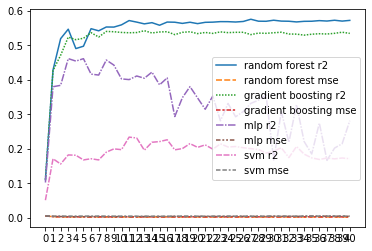

In [16]:
df1 = pd.DataFrame(randomForestMetrics, columns=["random forest r2", "random forest mse"])
df2 = pd.DataFrame(gradiendBoostingMetrics, columns=["gradient boosting r2", "gradient boosting mse"])
df3 = pd.DataFrame(mlpMetrics, columns=["mlp r2", "mlp mse"])
df4 = pd.DataFrame(svmMetrics, columns=["svm r2", "svm mse"])

g = sns.lineplot(data=pd.concat([df1,df2, df3, df4], axis=1))
g.set_xticks(range(0, 41))
print()

De acordo com o gráfico a acima iremos usar as 13 melhores features para treinar nosso modelos. É onde os melhores regressores tem o melhor desempenho com parametros default

In [17]:
X_new = SelectKBest(mutual_info_regression, k=13).fit_transform(X, y)
X_train, X_test, y_train, y_test = split_data(X_new, y)

## Seleção de hiperparametros

Iremos usar o framework Optuna para estimar os melhores hiperparametro rodando nosso modelos no conjunto de validação usando cross validation. As métricas que iremos utilizar para avaliar os modelos no conjunto de validação serão: r2 e MSE

In [18]:
def optimizeRandomForest(trial):
    n_estimators = trial.suggest_int('n_estimators', 1, 500)
    max_depth = trial.suggest_int('max_depth', 1, 200)
    model = RandomForestRegressor(n_estimators=n_estimators,
                                max_depth=max_depth, n_jobs=5, random_state=0)
    predicts = cross_val_predict(model, X_train, y_train)
    r2 = r2_score(y_train, predicts)
    mse = mean_squared_error(y_train, predicts)
    mlflow.start_run(run_name='random-forest-run')
    mlflow.log_params(trial.params)
    mlflow.log_metric("r2_score", r2)
    mlflow.log_metric("mean_squared_error", mse)
    mlflow.sklearn.log_model(model, "random-forest")
    mlflow.end_run()
    return r2

def optimizeGradientBoosting(trial):
    learning_rate = trial.suggest_loguniform("learning_rate", 0.0001, 5)
    n_estimators = trial.suggest_int('n_estimators', 1, 300)
    max_depth = trial.suggest_int('max_depth', 1, 200)
    model = GradientBoostingRegressor(learning_rate=learning_rate,
                                n_estimators=n_estimators,
                                max_depth=max_depth, random_state=0)
    predicts = cross_val_predict(model, X_train, y_train)
    r2 = r2_score(y_train, predicts)
    mse = mean_squared_error(y_train, predicts)
    mlflow.start_run(run_name='gradient-boosting-run')
    mlflow.log_params(trial.params)
    mlflow.log_metric("r2_score", r2)
    mlflow.log_metric("mean_squared_error", mse)
    mlflow.sklearn.log_model(model, "gradient-boosting")
    mlflow.end_run()
    return r2

def optimizeMlp(trial):
    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    n_layers = trial.suggest_int('n_layers', 1, 20)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int('layer ' + str(i), 1, 200))
    model = MLPRegressor(hidden_layer_sizes=tuple(layers),
                                activation=activation, random_state=0)
    predicts = cross_val_predict(model, X_train, y_train)
    r2 = r2_score(y_train, predicts)
    mse = mean_squared_error(y_train, predicts)
    mlflow.start_run(run_name='mlp-run')
    mlflow.log_params(trial.params)
    mlflow.log_metric("r2_score", r2)
    mlflow.log_metric("mean_squared_error", mse)
    mlflow.sklearn.log_model(model, "mlp")
    mlflow.end_run()
    return r2

def optimizeSvm(trial):
    C = trial.suggest_loguniform("C", 0.0001, 5)
    gamma = trial.suggest_loguniform("gamma", 0.0001, 5)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    model = SVR(gamma=gamma, C=C, kernel=kernel)
    predicts = cross_val_predict(model, X_train, y_train)
    r2 = r2_score(y_train, predicts)
    mse = mean_squared_error(y_train, predicts)
    mlflow.start_run(run_name='svm-run')
    mlflow.log_params(trial.params)
    mlflow.log_metric("r2_score", r2)
    mlflow.log_metric("mean_squared_error", mse)
    mlflow.sklearn.log_model(model, "svm")
    mlflow.end_run()
    return r2

n_trials=1 # usamos um trials de 5000 para executar os testes
timeout=1 # com timeout de 2hrs por modelo

randomForestStudy = optuna.create_study(direction='maximize')
randomForestStudy.optimize(optimizeRandomForest, n_trials=n_trials, timeout=timeout)

gradientBoostingStudy = optuna.create_study(direction='maximize')
gradientBoostingStudy.optimize(optimizeGradientBoosting, n_trials=n_trials, timeout=timeout)

mlpStudy = optuna.create_study(direction='maximize')
mlpStudy.optimize(optimizeMlp, n_trials=n_trials, timeout=timeout)

svmStudy = optuna.create_study(direction='maximize')
svmStudy.optimize(optimizeSvm, n_trials=n_trials, timeout=timeout)

[I 2021-04-22 22:28:13,301] A new study created in memory with name: no-name-96b35daf-b7bb-4296-8c6b-bd8b4c5b5ece
[I 2021-04-22 22:28:22,390] Trial 0 finished with value: 0.5689413232902372 and parameters: {'n_estimators': 324, 'max_depth': 157}. Best is trial 0 with value: 0.5689413232902372.
[I 2021-04-22 22:28:22,391] A new study created in memory with name: no-name-53a27056-78de-441f-bfa0-0e2a2daeac79
[I 2021-04-22 22:28:49,436] Trial 0 finished with value: 0.2467498062048883 and parameters: {'learning_rate': 0.025049010938043355, 'n_estimators': 215, 'max_depth': 28}. Best is trial 0 with value: 0.2467498062048883.
[I 2021-04-22 22:28:49,436] A new study created in memory with name: no-name-5ffe92ea-0012-49a3-9993-9ed5b53f5923
[I 2021-04-22 22:29:12,117] Trial 0 finished with value: 0.17573323014153275 and parameters: {'activation': 'identity', 'n_layers': 17, 'layer 0': 7, 'layer 1': 39, 'layer 2': 90, 'layer 3': 24, 'layer 4': 153, 'layer 5': 149, 'layer 6': 149, 'layer 7': 154,

Agora iremos pegar os melhores hiperparametros para os modelos e iremos testar-los sobre o conjunto de teste

In [19]:
best_random_forest_run = mlflow.search_runs(
    filter_string="tag.mlflow.runName = 'random-forest-run'", 
    max_results=1, 
    order_by=["metric.r2_score DESC"]
)
best_gradient_boosting_run = mlflow.search_runs(
    filter_string="params.learning_rate != ''", 
    max_results=1, 
    order_by=["metric.r2_score DESC"]
)
best_mlp_run = mlflow.search_runs(
    filter_string="params.activation != ''", 
    max_results=1, 
    order_by=["metric.r2_score DESC"]
)
best_svm_run = mlflow.search_runs(
    filter_string="params.C != ''", 
    max_results=1, 
    order_by=["metric.r2_score DESC"]
)

In [20]:
best_random_forest_model = mlflow.sklearn.load_model(best_random_forest_run.artifact_uri[0] + '/random-forest')
best_gradient_boosting_model = mlflow.sklearn.load_model(best_gradient_boosting_run.artifact_uri[0] + '/gradient-boosting')
best_mlp_model = mlflow.sklearn.load_model(best_mlp_run.artifact_uri[0] + '/mlp')
best_svm_model = mlflow.sklearn.load_model(best_svm_run.artifact_uri[0] + '/svm')
best_random_forest_model.fit(X_train, y_train)
best_gradient_boosting_model.fit(X_train, y_train)
best_mlp_model.fit(X_train, y_train)
best_svm_model.fit(X_train, y_train)
print()

In [21]:
import scipy as sp
sns.set()

def evaluateModel(model, name, charts=False):
    predictions = model.predict(X_test)
    if charts:
        fig, ax = plt.subplots(3, 1, figsize=(20,10))
        fig.suptitle('Analise normalidade e residuos do ' + name)
        sp.stats.probplot((y_test-predictions), plot=ax[0], fit=True)
        sns.residplot(predictions, y_test, color="g", ax=ax[1])
        sns.distplot((y_test-predictions), hist=True, kde=True, ax=ax[2])
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    print('Métricas do modelo ' + name)
    print('R2', r2)
    print('MSE', mse)
    print()
    return predictions

In [22]:
import warnings
warnings.filterwarnings('ignore')

evaluateModel(best_random_forest_model, 'Random Forest')
evaluateModel(best_gradient_boosting_model, 'Gradient Boosting')
evaluateModel(best_mlp_model, 'MLP')
evaluateModel(best_svm_model, 'SVM')

Métricas do modelo Random Forest
R2 0.5773883696211873
MSE 0.0024651535511027423

Métricas do modelo Gradient Boosting
R2 0.5813796961690237
MSE 0.0024418715775229097

Métricas do modelo MLP
R2 0.5050935393422217
MSE 0.002886859544922209

Métricas do modelo SVM
R2 0.20724965976189824
MSE 0.0046242251180454936



array([0.23146437, 0.23922921, 0.29131321, ..., 0.24416951, 0.35063756,
       0.21482348])

Comos podemos observar o melhor modelo foi o que utiliza o Gradient Boosing, com R2 de 0.58 e MSE 0.00244. 

## Diagnostico melhor modelo

Métricas do modelo Gradient Boosting
R2 0.5813796961690237
MSE 0.0024418715775229097

Menor valor no conjunto de test 0.11
Maior conjunto de teste 0.66
Maior erro quadrado possivel 0.30250000000000005


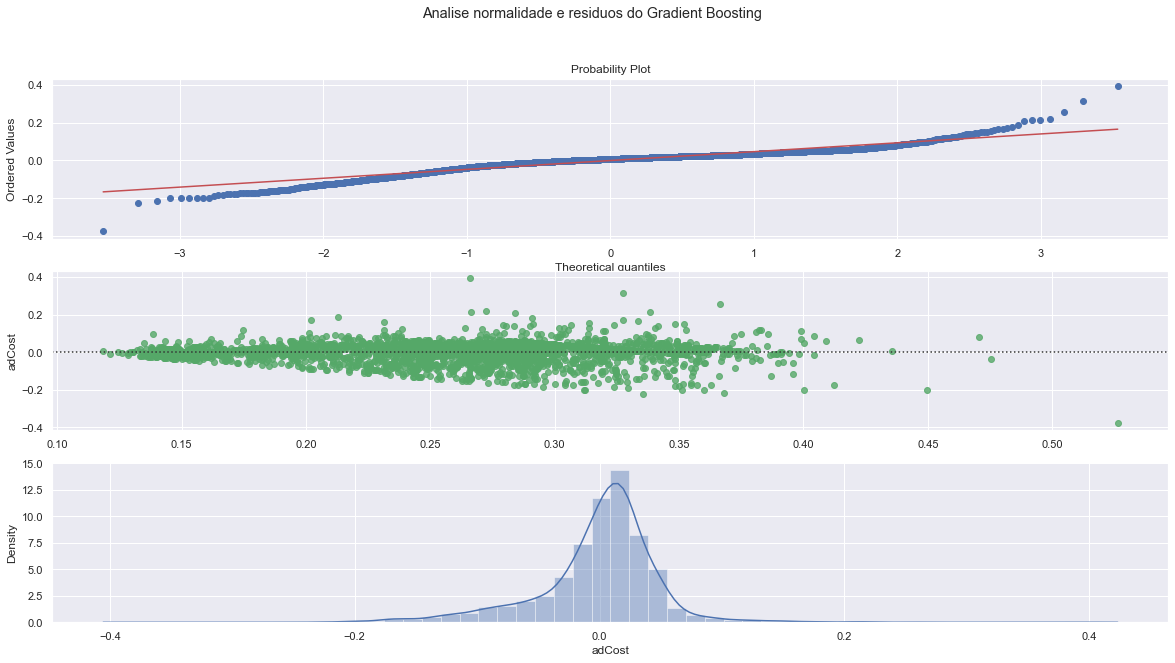

In [23]:
bestPredictions = evaluateModel(best_gradient_boosting_model, 'Gradient Boosting', True)
print('Menor valor no conjunto de test ' + str(y_test.min()))
print('Maior conjunto de teste ' + str(y_test.max()))
print('Maior erro quadrado possivel ' + str((y_test.max() - y_test.min()) ** 2))

Olhando para as métricas r2 e mse nós temos um modelo muito bom, pois o maior erro quadrado possivel seria 0.3 e o nosso erro médio quadrado seria 0.002, mas observando nosso gráfico de residuos percebemos que os erros não seguem uma normal bem definida, eles estão tendendo para entregar maiores erros negativos quando o nosso valor previsto tende a ser maior do que 0.3.

Para tentar melhorar esse modelo iremos rodar um SHAP e remover algumas features que estejam pesando negativamente a nossa predição.

In [24]:
explainer = shap.Explainer(best_gradient_boosting_model)
shap_values = explainer(X_test)

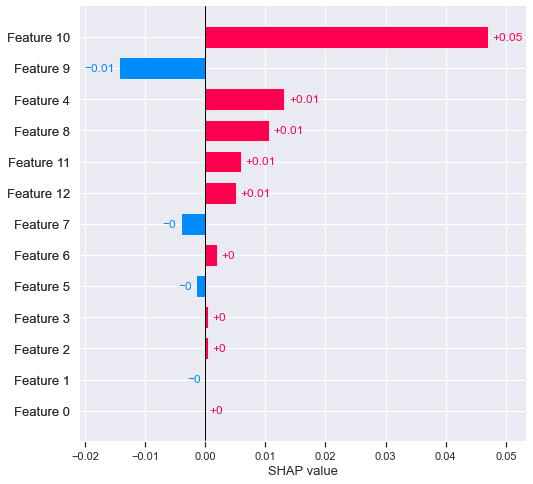

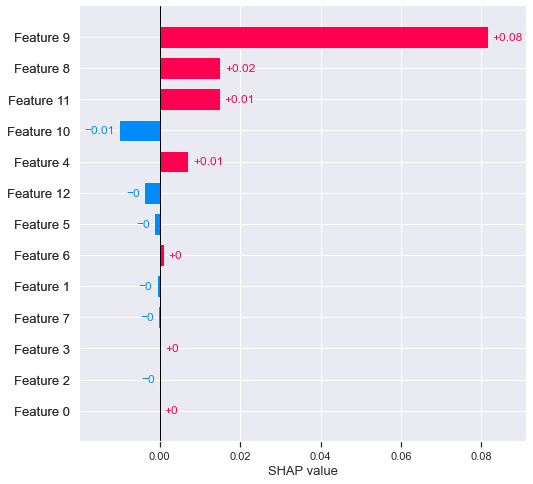

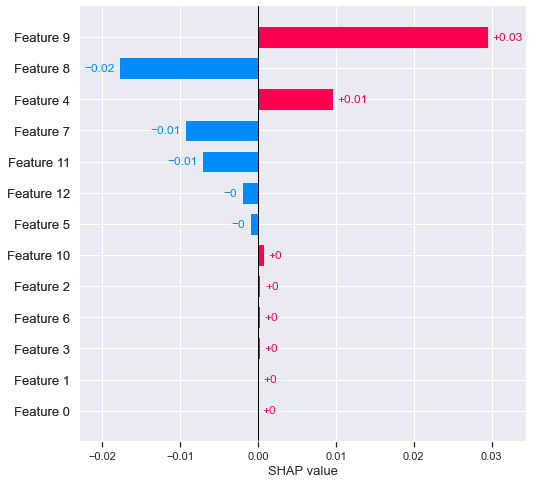

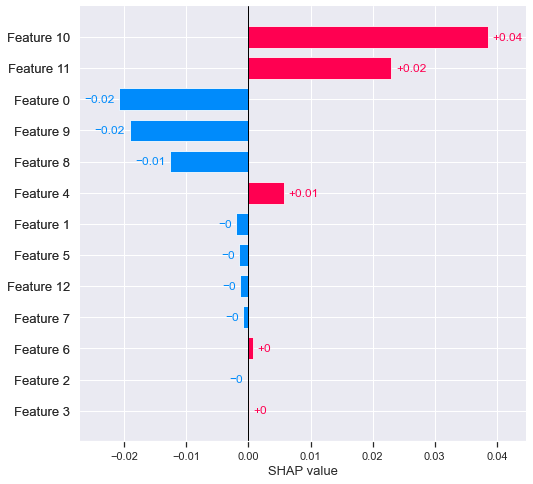

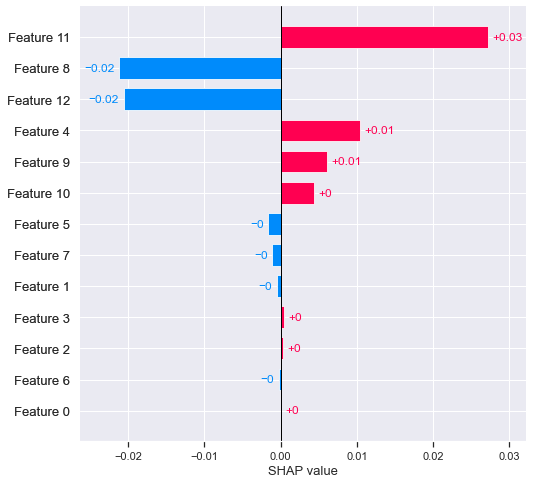

In [25]:
k = 5
smallestNegativeErrors = np.argpartition((bestPredictions - np.array(y_test)), k)
shap.plots.bar(shap_values[smallestNegativeErrors[0]], max_display=13)
shap.plots.bar(shap_values[smallestNegativeErrors[1]], max_display=13)
shap.plots.bar(shap_values[smallestNegativeErrors[2]], max_display=13)
shap.plots.bar(shap_values[smallestNegativeErrors[3]], max_display=13)
shap.plots.bar(shap_values[smallestNegativeErrors[4]], max_display=13)

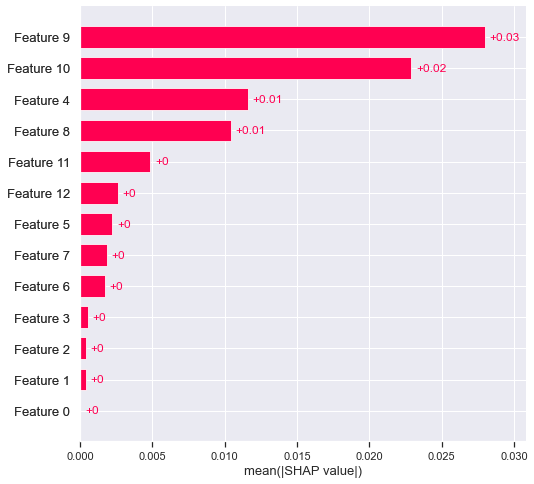

In [26]:
shap.plots.bar(shap_values, max_display=13)

Decidimos tirar as features 0,1,2, pois elas tem pouco impacto(quase zero) no modelo e ou impactam negativamente na predição

Decidimos tirar as features 6 e 7, pois ela impacta negativamente na maioria das nossas amostras. Embora as feature 12 e 4 também impactem negativamente nas nossas 5 amostras, removendo-as o nosso r2 caiu em +- 5 pontos.

O resto das feature tem um impacto significativo no nosso modelo como podemos ver no gráfico global(ultimo gráfico), embora não saibamos se é negativo ou positivo, pois o gráfico só leva em conta o valor absoluto. Remover qualquer um dessas feature tem um impacto negativa demais de 5 pontos no R2

In [27]:
X_train_after_shap = np.delete(X_train, [0,1,2,6,7], 1)
X_test_after_shap = np.delete(X_test, [0,1,2,6,7], 1)

Métricas do modelo gb
R2 0.5939176807517441
MSE 0.0023687357360174127



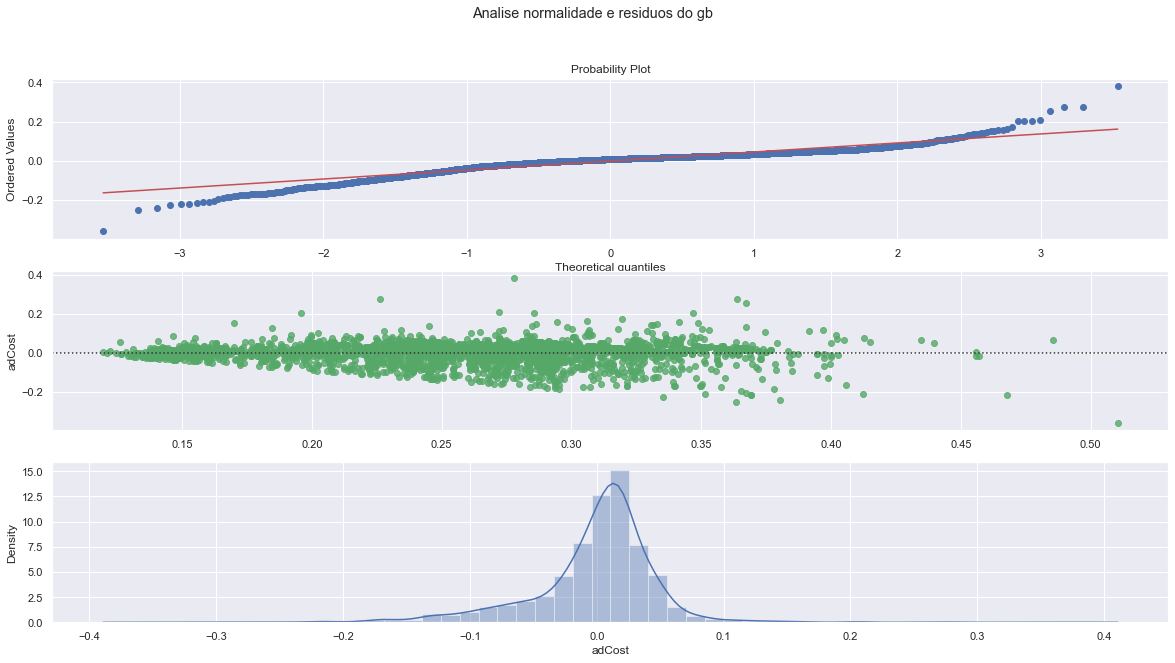

In [28]:
from sklearn.base import clone
gb_after_shap = clone(best_gradient_boosting_model)
gb_after_shap.fit(X_train_after_shap, y_train)
predictions = gb_after_shap.predict(X_test_after_shap)
fig, ax = plt.subplots(3, 1, figsize=(20,10))
fig.suptitle('Analise normalidade e residuos do gb')
sp.stats.probplot((y_test-predictions), plot=ax[0], fit=True)
sns.residplot(predictions, y_test, color="g", ax=ax[1])
sns.distplot((y_test-predictions), hist=True, kde=True, ax=ax[2])
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
print('Métricas do modelo gb')
print('R2', r2)
print('MSE', mse)
print()

Removendo as feature mencionando anteriormente conseguimos aumentar o nosso r2 em + de 1 ponto e diminuirmos o nosso MSE em 0,001. Nosso gráfico de residuo ainda tem uma leve tendencia negativa, mas ela foi levemente corrigida com a remoção das features e podemos observa isso a parti de 0.30 no eixo x. Podemos observar que a normalidade dos residuos também melhorou, as extremidades estão muito mais proximas da normal.

Como podemos observar, o terceiro gráfico mostra que nosso residuos seguem uma distruibuição gaussiana e a partir dos pressuspostos(residuos dispostos aleatoriamente em torno da linha 0 do grafico 1, formam uma faixa horizontal e seguem uma distribuição normal) visto na aula o nosso modelo é bom suficiente para generalizar a população, ou seja não estamos sofrendo com overfitting. E como nosso MSE é muito baixo, no conjunto de treino e no conjunto de teste, em relação ao maior erro quadrático que poderiamos ter(0.3), o nosso modelo também não está sofrendo com underfit. Temos uma baixo viés e uma variânca relativamente baixa